<a href="https://colab.research.google.com/github/gorogoro-uk/NLP-project/blob/master/Sherlock_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sherlock Holmes Text prediction project

In [ ]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive")

In [46]:
# import code
import os
import sys
from pathlib import Path
import string
import datetime
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
import numpy as np
import tensorflow.keras.utils as ku
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import regularizers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [50]:
# define directories on Google Drive
SHERLOCK_DIR = './drive/My Drive/sherlock'
print(f"SHERLOCK_DIR: {SHERLOCK_DIR}")
print(Path(SHERLOCK_DIR))
STORY_DIR = Path(SHERLOCK_DIR) / 'story'
MODEL_DIR = Path(SHERLOCK_DIR) / 'model'
LOG_DIR = Path(SHERLOCK_DIR) / 'log'
if not os.path.exists(STORY_DIR):
  os.mkdir(STORY_DIR)
if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)
if not os.path.exists(LOG_DIR):
  os.mkdir(LOG_DIR) 
print(f"STORY_DIR: {STORY_DIR}")
print(f"contents of STORY_DIR:    {os.listdir(STORY_DIR)}")
print(f"MODEL_DIR: {MODEL_DIR}")
print(f"contents of MODEL_DIR:    {os.listdir(MODEL_DIR)}")
print(f"LOG_DIR: {LOG_DIR}")
print(f"contents of LOG_DIR:    {os.listdir(LOG_DIR)}")

SHERLOCK_DIR: ./drive/My Drive/sherlock
drive/My Drive/sherlock
STORY_DIR: drive/My Drive/sherlock/story
contents of STORY_DIR:    ['sh_short.txt', 'sh_text_2.txt', 'sh_text_1.txt', 'sh_text_3.txt', 'sh_text_4.txt', 'sh_text_5.txt', 'sh_text_7.txt', 'sh_text_6.txt']
MODEL_DIR: drive/My Drive/sherlock/model
contents of MODEL_DIR:    ['model.data-00000-of-00001', 'model.index', 'checkpoint']
LOG_DIR: drive/My Drive/sherlock/log
contents of LOG_DIR:    ['train']


In [32]:
# import story text files
#story_files = ['sh_text_1.txt','sh_text_2.txt','sh_text_3.txt','sh_text_4.txt','sh_text_5.txt','sh_text_6.txt','sh_text_7.txt']
story_files = ['sh_text_1.txt','sh_text_2.txt']

# data structure: list of strings, each string is one txt story file
story_list = []
for story_file in story_files:
  with open(os.path.join(STORY_DIR, story_file),encoding='utf-8-sig') as reader:
    print(f"story_file: {os.path.join(STORY_DIR, story_file)}")
    raw_story_string = reader.read()
    story_list.append(raw_story_string)

print(f"story_list length:  {len(story_list)}")
print(f"story type: {type(story_list[0])}")

story_file: drive/My Drive/sherlock/story/sh_text_1.txt
story_file: drive/My Drive/sherlock/story/sh_text_2.txt
story_list length:  2
story type: <class 'str'>


In [38]:
# Pre-process Texts
# remove most punctuation & chapter numbers
# keep sentence ending punctuation [.?!] to allow sentence splitting below
# include other angled quote marks found in the text [”“‘’]
# remove end of line \n
# remove chapter headings, Roman numerals & Arabic numerals
# keep the pronoun 'I', 'I.'
# split into sentences using NLTK
# remove sentence ending punctuation, whitespace and make lowercase

punc_string = "\"#$%&'()*+,-/:;<=>@[\]^_`{|}~'”“‘’—"
print(f"punc string:  {punc_string}")

story_list_2 = []
for story in story_list:

    # clean up text
    # data structure: list of stories, each sotry a single string
    #print(f"BEFORE punc:\n{story[:100]}")
    tt = story.maketrans('', '', punc_string)                                   # remove punctuation
    story = story.translate(tt)
    story = story.replace('\n',' ')                                             # remove end of line character
    story = re.sub('(CHAPTER|Chapter|PART)','',story)                           # remove chapter headings
    story = re.sub('(XIII|XII|XI|X|IX|VIII|VII|VI|V|IV|III|II)(\.?)','',story)  # remove Roman numeral chaper numbers
    story = re.sub('(\d+)\.\s','',story)                                        # remove Arabic numeral chaper numbers
    #print(f"AFTER punc :\n{story[:100]}")

    # split into sentences
    # data structure: list of stories, each story a list of strings, one for each sentence
    new_story = nltk.tokenize.sent_tokenize(story)
    #print(f"AFTER sentence :\n{new_story[:100]}")

    # add updated story to list
    story_list_2.append(new_story)

punc string:  "#$%&'()*+,-/:;<=>@[\]^_`{|}~'”“‘’—


In [39]:
# remove sentence ending punctuation [.?!]
story_list_3 = []
for story in story_list_2:
    new_story = []
    for sentence in story:
        sentence = sentence.translate(sentence.maketrans('','','.?!'))
        sentence = sentence.replace('/t','')
        sentence = sentence.strip()
        new_sentence = sentence.lower()
        new_story.append(new_sentence)
    print(f"AFTER :\n{new_story[:100]}")
    story_list_3.append(new_story)

AFTER :
['a scandal in bohemia   i', 'to sherlock holmes she is always the woman', 'i have seldom heard him mention her under any other name', 'in his eyes she eclipses and predominates the whole of her sex', 'it was not that he felt any emotion akin to love for irene adler', 'all emotions and that one particularly were abhorrent to his cold precise but admirably balanced mind', 'he was i take it the most perfect reasoning and observing machine that the world has seen but as a lover he would have placed himself in a false position', 'he never spoke of the softer passions save with a gibe and a sneer', 'they were admirable things for the observerexcellent for drawing the veil from mens motives and actions', 'but for the trained reasoner to admit such intrusions into his own delicate and finely adjusted temperament was to introduce a distracting factor which might throw a doubt upon all his mental results', 'grit in a sensitive instrument or a crack in one of his own highpower lenses wou

In [40]:
# tokenize words, create word_index
vocab_size = 500
print(f"vocab_size: {vocab_size}")
tokenizer = Tokenizer(num_words=vocab_size,oov_token='OOV')
for story in story_list_3:
    tokenizer.fit_on_texts(story)
total_words = len(tokenizer.word_index) + 1
print(f"total_words: {total_words}")
#print(f"tokenized text: {tokenizer.get_config()}")

# convert to token sequences based on word_index
seq_list = []
for story in story_list_3:
    seq = tokenizer.texts_to_sequences(story)
    seq_list.append(seq)
print(f"sequence list:  {seq_list[0][:10]}")

vocab_size: 500
total_words: 10763
sequence list:  [[7, 1, 8, 1, 4], [6, 124, 40, 44, 15, 221, 2, 226], [4, 18, 1, 129, 30, 1, 36, 246, 96, 86, 191], [8, 14, 125, 44, 1, 3, 1, 2, 217, 5, 36, 1], [10, 12, 27, 9, 11, 329, 96, 1, 1, 6, 1, 23, 1, 1], [38, 1, 3, 9, 42, 1, 43, 1, 6, 14, 1, 1, 26, 1, 1, 185], [11, 12, 4, 165, 10, 2, 146, 1, 1, 3, 1, 1, 9, 2, 1, 62, 174, 26, 19, 7, 1, 11, 51, 18, 1, 141, 8, 7, 1, 1], [11, 118, 284, 5, 2, 1, 1, 359, 20, 7, 1, 3, 7, 1], [59, 43, 1, 390, 23, 2, 1, 23, 1, 2, 1, 33, 1, 1, 3, 1], [26, 23, 2, 1, 1, 6, 1, 111, 1, 60, 14, 119, 1, 3, 1, 1, 1, 12, 6, 1, 7, 1, 1, 22, 105, 1, 7, 207, 34, 38, 14, 1, 1]]


In [41]:
# create n-grams of increasing length from each sequence in corpus
n_gram_list = []
for story in seq_list:
    for sentence in story:
        for i in range(1, len(sentence)):
            n_gram_seq = sentence[:i+1]
            n_gram_list.append(n_gram_seq)
print(f"n-gram sequences:\n{n_gram_list[:10]}")
print(len(n_gram_list))

# pad from left, convert to numpy array
max_seq_len = max([len(x) for x in n_gram_list])
print(f"max seq len: {max_seq_len}")
pad_seq_list = np.array(pad_sequences(n_gram_list, maxlen=max_seq_len, padding='pre'))
print(f"pad_seq_list: {pad_seq_list.shape}")

n-gram sequences:
[[7, 1], [7, 1, 8], [7, 1, 8, 1], [7, 1, 8, 1, 4], [6, 124], [6, 124, 40], [6, 124, 40, 44], [6, 124, 40, 44, 15], [6, 124, 40, 44, 15, 221], [6, 124, 40, 44, 15, 221, 2]]
138181
max seq len: 101
pad_seq_list: (138181, 101)


In [42]:
# create feature and label arrays
features= pad_seq_list[:,:-1]
print(f"features: {features.shape}")
labels_seq = np.expand_dims(pad_seq_list[:,-1], axis=1)
print(f"labels: {labels_seq.shape}")
labels_hot = ku.to_categorical(labels_seq, num_classes=vocab_size)     # one hot encoding
print(f"labels_hot:{labels_hot.shape}\n{labels_hot[:3]}")

features: (138181, 100)
labels: (138181, 1)
labels_hot:(138181, 500)
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [47]:
#### CALLBACKS ####

# model save checkpoint callback
print(MODEL_DIR)
sav_cb = ModelCheckpoint(filepath=Path(MODEL_DIR),
                          save_weights_only=True,
                          verbose=1,
                          save_freq='epoch')
print("ModelCheckpoint callback defined")

# save weights manually (or sue callback in training loop to save regulary)
#model.save_weights('./checkpoints/my_checkpoint')

# Tensorboard callback
print(LOG_DIR)
TBD_LOG = Path(LOG_DIR) / datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print(TBD_LOG)
tbd_cb = TensorBoard(log_dir=TBD_LOG, histogram_freq=1)

print("Tensorboard callback defined")

drive/My Drive/sherlock/model
ModelCheckpoint callback defined
drive/My Drive/sherlock/log
drive/My Drive/sherlock/log/20200907-162925
Tensorboard callback defined


In [17]:
#### MODEL ####

# function to create  model
def create_model(embed_size, seq_length, words, lstm_units1, lstm_units2):
    model = Sequential([                                                               # [batch, seq_length] input tensor
        Embedding(words, embed_size, input_length=seq_length),                         # [batch, seq_length, embed_size]
        Bidirectional(LSTM(lstm_units1, return_sequences = True)),                     # [batch, seq_length, 2*lstm_units]
        Dropout(0.2),                                                                  # [batch, same as prev, same as prev]
        LSTM(lstm_units2),                                                             # [batch, lstm_units]
        Dense(words/4, activation='relu', kernel_regularizer=regularizers.l2(0.01)),   # [batch, dense_units]
        Dense(words, activation='softmax')                                             # [batch, dense_units]
    ])
    model.summary()
    model.compile(loss='categorical_crossentropy',
                    optimizer='Adam',
                    metrics=['accuracy'])
    print("model created")
    return model

# define model
embed_size = 10
bi_lstm_units = 10
lstm_units = 10
sh_model = create_model(embed_size, max_seq_len-1, vocab_size, bi_lstm_units, lstm_units)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 106, 10)           5000      
_________________________________________________________________
bidirectional (Bidirectional (None, 106, 20)           1680      
_________________________________________________________________
dropout (Dropout)            (None, 106, 20)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1240      
_________________________________________________________________
dense (Dense)                (None, 125)               1375      
_________________________________________________________________
dense_1 (Dense)              (None, 500)               63000     
Total params: 72,295
Trainable params: 72,295
Non-trainable params: 0
____________________________________________________

In [18]:
# fit model
sh_model_hist = sh_model.fit(features, labels_hot, epochs=2, verbose=2, callbacks=[tbd_cb, sav_cb])

Epoch 1/2
Instructions for updating:
use `tf.profiler.experimental.stop` instead.

Epoch 00001: saving model to drive/My Drive/sherlock/model
15045/15045 - 1176s - loss: 4.0321 - accuracy: 0.2600
Epoch 2/2

Epoch 00002: saving model to drive/My Drive/sherlock/model
15045/15045 - 1167s - loss: 3.7138 - accuracy: 0.2758


In [30]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard

# run tensorboard (can also run from console)
print(LOG_DIR)
#%tensorboard --logdir LOG_DIR
#%tensorboard --inspect --logdir LOG_DIR   # to check the files exist in directory


drive/My Drive/sherlock/log


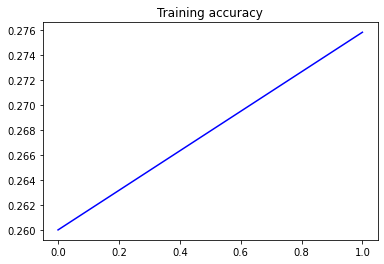

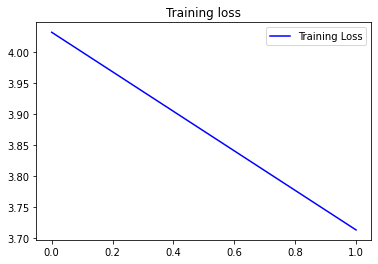

In [25]:
# plot learning results
import matplotlib.pyplot as plt
acc = sh_model_hist.history['accuracy']
loss = sh_model_hist.history['loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [ ]:
# restore saved model 

# confirm weights file saved
print(os.listdir(checkpoint_dir))

# Create a basic model instance
restored_sh_model = create_model(embedding_size, max_seq_len-1, total_words)

# Loads the saved model weights
restored_sh_model.load_weights(checkpoint_path)

# Re-evaluate the model
#loss,acc = restored_sh_model.evaluate(test_images,  test_labels, verbose=2)
#print("Restored model, accuracy: {:5.2f}%".format(100*acc))

['sh_short.txt', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index', 'checkpoint']


In [ ]:
# use model to make a prediction
seed_text = "hello watson"
next_words = 20

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_seq_len - 1, padding='pre')
    predicted = restored_sh_model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

hello watson as i am in the photograph he said he i had been unlikely it lead things by a room with
